# Implementing the k-means and DBSCAN clustering algorithm from scratch and applying the implementation to new data

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.datasets

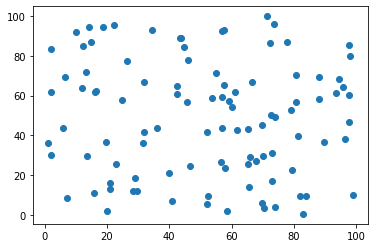

In [31]:
data = np.random.rand(100,2) * 100 # The dimensionality of the input doesn't matter.
plt.scatter(data[:,0], data[:,1])

## 1. k-means clustering

The K-means clustering algorithm will be implemented as follows:
1. Select k random points as the centroids of the new clusters.
2. Loop the following procedure:
    * Assign each point to the centroid that is the minimum Euclidean distance away from the point.
    * Calculate the centroid of the new cluster $\displaystyle \vec{C}_n = \frac{1}{N}\sum \vec{p}_n$, where $N$ is the number of points in the cluster.

In [32]:
class KMeans:
    def KPP_centroids(data, k):
        centroids = [data[np.random.choice(data.shape[0], 1, False)]]
        for i in range(k-1):
            dist = np.array([KMeans.min_centroid_dist(p, centroids)**2 for p in data])
            dist = dist/np.sum(dist)
            centroids.append(data[np.random.choice(data.shape[0], 1, p=dist)])
        return np.array(centroids)

    def min_centroid(pt, centroids):
        return np.argmin([np.linalg.norm(pt-ct) for ct in centroids])
    
    def min_centroid_dist(pt, centroids):
        return np.min([np.linalg.norm(pt-ct) for ct in centroids])

    def update_centroids(data, centroids):
        assign = [KMeans.min_centroid(p, centroids) for p in data]

        N = np.array([0 for _ in range(centroids.shape[0])])
        vec_sum = np.array([np.zeros(data.shape[1]) for _ in range(centroids.shape[0])])
        for pt in range(data.shape[0]):
            N[assign[pt]] += 1
            vec_sum[assign[pt]] += data[pt]
        centroids = np.array([vec/n for vec, n in zip(vec_sum, N)])
        return centroids, assign

    def k_means(data, k, reps=1000, min_dist=None):
        if(reps != None):
            centroids = KMeans.KPP_centroids(data, k)
            for i in range(reps):
                centroids, assign = KMeans.update_centroids(data, centroids)
        elif(min_dist != None):
            old_centroids = KMeans.KPP_centroids(data, k)
            centroids, _ = KMeans.update_centroids(data, old_centroids)
            while(np.min(np.abs(centroids-old_centroids)) > min_dist):
                old_centroids = centroids
                centroids, assign = KMeans.update_centroids(data, old_centroids)

        return centroids, assign

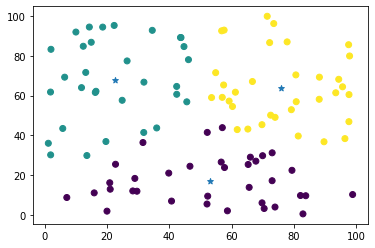

In [33]:
centroids, category = KMeans.k_means(data, 3, reps=100, min_dist=None)
plt.scatter(data[:,0], data[:,1], c=category)
plt.scatter(centroids[:,0], centroids[:,1], marker="*")

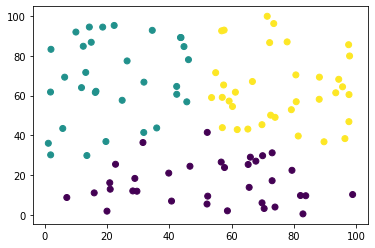

In [34]:
kmeans_model = sklearn.cluster.KMeans(3, init="k-means++", max_iter=100, tol=0).fit(data)
plt.scatter(data[:,0], data[:,1], c=kmeans_model.labels_)

## 2. DBSCAN clustering

The algorithm will be implemented as follows:
0. Given hyperparameters $\epsilon$ (minimum distance) and $N$ (minimum neighbors)...
1. Select a random point in the dataset.
2. Find all points in the dataset which are within $\epsilon$ distance from the original point.
3. If the number of points is greater than $N$...
    - Give the point a new unique label
    - For each of the neighboring points that do NOT already have a label...
        - Run the DBSCAN algorithm on that point.
4. Else, mark the point as noise and choose another random point.

In [35]:
class DBSCAN:                
    def distance(p1, p2):
        return np.linalg.norm(p2-p1)
        
    def DBSCAN_rec(data, labels, pt, epsilon, N, ts=None):
        if(labels[pt] > 0):
            return labels
        
        if(ts != None): # Only set as a new cluster if not designated as a border point
            labels[pt] = ts
        else:
            labels[pt] = max(labels) + 1
            
        close = [DBSCAN.distance(data[pt], x) <= epsilon for x in data]
        if(sum(close) >= N):
            for i in range(data.shape[0]):
                if(close[i] and i != pt):
                    labels = DBSCAN.DBSCAN_rec(data, labels, i, epsilon, N, ts=labels[pt]) # If this happens, the new point is not an outlier/in a new cluster!

        else:
            if(ts == None): # Only set as an outlier if not designated as a border point
                labels[pt] = -1
        
        return labels
        
                    
    def DBSCAN(data, epsilon, N):
        labels = [0 for _ in range(data.shape[0])]
        
        order_of_visit = np.arange(data.shape[0]) # To make order of point visiting completely random
        np.random.shuffle(order_of_visit)
        
        for pt in order_of_visit:
            labels = DBSCAN.DBSCAN_rec(data, labels, pt, epsilon, N) # defaults to ts=None
        
        return labels

[1, 1, 1, 9, 11, 5, -1, -1, -1, -1, -1, 9, 4, 7, 5, -1, 1, 4, 1, 5, 2, 8, 1, 3, 2, 5, -1, 3, 6, -1, 3, 8, -1, -1, -1, 11, 5, 8, 3, 3, 2, 4, 6, 10, -1, -1, 4, 3, 10, -1, 6, -1, -1, 1, 7, 9, 6, 11, 5, 5, 5, 5, 1, 12, 6, 5, -1, 1, 1, 5, 11, 9, 5, 7, -1, 7, 4, 7, 5, -1, 5, -1, -1, 12, 8, 10, -1, 8, -1, 8, 4, 6, 5, 1, 6, -1, 7, 5, -1, 12]


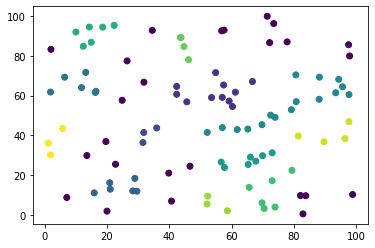

In [36]:
labels = DBSCAN.DBSCAN(data, 9, 3) # eps=9, min_samples=3 (including self)
print(labels)

plt.scatter(data[:,0], data[:,1], c=labels)

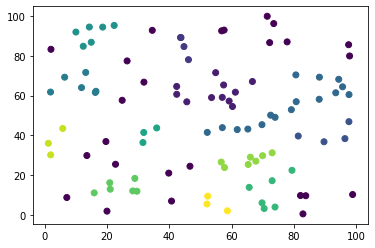

In [37]:
dbscan_labels = sklearn.cluster.DBSCAN(eps=9, min_samples=3).fit(data).labels_
plt.scatter(data[:,0], data[:,1], c=dbscan_labels)

Note that the two outputs for my own implementation and the official sklearn implementation are identical.

# 3. Applying my implementation to new datasets

## 3.1 The "moons" dataset

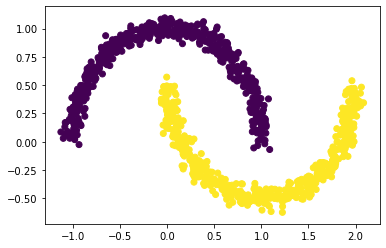

In [38]:
# The original dataset, with "ground truth labels"
moons_data, moons_labels = sklearn.datasets.make_moons(n_samples=1000, noise=.05)
plt.scatter(moons_data[:,0], moons_data[:,1], c=moons_labels)

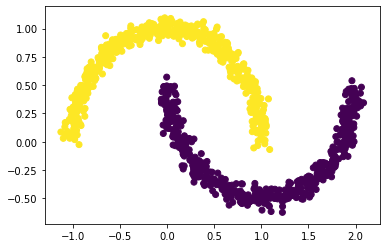

In [39]:
# The classifications provided by DBSCAN, run time approx. 8 seconds for 1000 points
DBSCAN_moons_labels = DBSCAN.DBSCAN(moons_data, 0.2, 5)
plt.scatter(moons_data[:,0], moons_data[:,1], c=DBSCAN_moons_labels)

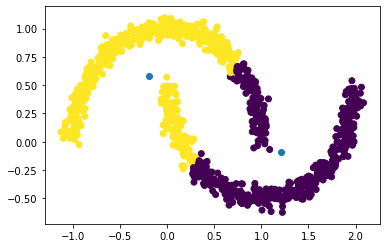

In [40]:
# The classifications provided by k-means, with the blue points representing the centroids of the two classes.
KMeans_moons_centroids, KMeans_moons_labels = KMeans.k_means(moons_data, 2, reps=None, min_dist=1e-4)
plt.scatter(moons_data[:,0], moons_data[:,1], c=KMeans_moons_labels)
plt.scatter(KMeans_moons_centroids[:,0], KMeans_moons_centroids[:,1])

Note the difference in clusters between the K-means algorithm and the DBSCAN algorithm. This is because of the inherent way that each individual algorithm works—because the K means uses a centroid model, it will just take points that are close to a determined centroid. However, because of the shape of the dataset is not multiple independent blobs, but almost overlapping crescent sections, the K-means algorithm is unable to use Euclidean distance to differentiate the clusters.

However, the DBSCAN algorithm simply finds points that are close to each other and determines a cluster based on the similarity of each point to neighboring points, so given a small enough $\epsilon$ value, the DBSCAN algorithm will be able to split the crescents into their "ground truth" labels.

## 3.2 The "blobs" dataset, with $n = 5$

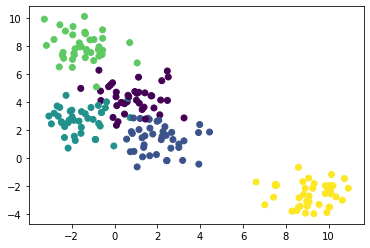

In [48]:
blobs_data, blobs_labels = sklearn.datasets.make_blobs(n_samples=200, centers=5, random_state=0) # Note random_state (the seed) is set at 0.
plt.scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels)

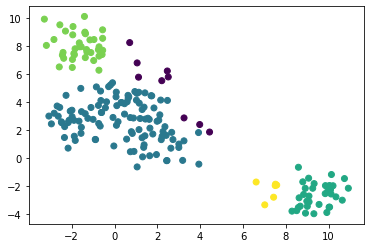

In [55]:
# The classifications provided by DBSCAN. Purple points are outliers.
DBSCAN_blobs_centroids = DBSCAN_blobs_labels = DBSCAN.DBSCAN(blobs_data, 1, 5)
plt.scatter(blobs_data[:,0], blobs_data[:,1], c=DBSCAN_blobs_labels)

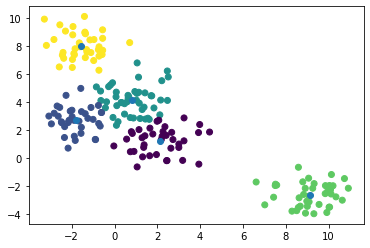

In [54]:
# The classifications provided by DBSCAN
KMeans_blobs_centroids, KMeans_blobs_labels = KMeans.k_means(blobs_data, 5, reps=None, min_dist=1e-4)
plt.scatter(blobs_data[:,0], blobs_data[:,1], c=KMeans_blobs_labels)
plt.scatter(KMeans_blobs_centroids[:,0], KMeans_blobs_centroids[:,1])

The results produced by DBSCAN and K-means for these datasets are interesting because the location of the clusters heavily dictates the results for both algorithms. For example, the DBSCAN algorithm will lump the points into less than five clusters, especially when multiple clusters are located near each other, as in the dataset above. This is one of the major downsides of DBSCAN—it is good at determining clusters that are far apart, but as they get closer together clusters will begin to "merge" as the distances between the two closest points decreases below $\epsilon$.

On the other hand, k-means is forced to generate five clusters and will place centroids accordingly. This means that assuming the centroids have good enough initial placement (not too close together, which is the point of k-means++), it will find reasonable clusters that seem to match the "ground truth" labels provided by sklearn.